In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import ipywidgets as widgets

pd.set_option("display.max_rows", 1000)

exp_path = Path("../experiments/issue_32/")
tex_path = exp_path / "tex_files"
tex_path.mkdir(exist_ok=True)

In [2]:
!ls /home/paulo/Documents/GIT/BCI_MsC/experiments/issue_32/results/

1  2  3  4  5  6  7  8	9  results.csv


In [3]:
df = pd.read_csv("/home/paulo/Documents/GIT/BCI_MsC/experiments/issue_32/results/results.csv")
uids = df.uid.unique()

full_df = df[~df.algorithm.isin(["pca", "whitening"])]


In [4]:
full_df.run.unique(), full_df.uid.unique()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [5]:
full_df.algorithm.unique(), full_df.classifier.unique()

(array(['None', 'ORICA (0)', 'ORICA (1)', 'Ext. Infomax', 'Infomax',
        'SOBI', 'JADE', 'Picard', 'FastICA', 'picard_o'], dtype=object),
 array(['mlp', 'random_forest', 'extra_trees', 'gaussian_nb', 'lda',
        'svm_sigmoid', 'svm_poly', 'svm_linear', 'svm_rbf', 'logistic_l2',
        'logistic_l1', 'logistic'], dtype=object))

In [6]:
def get_default(get_fn):
    def fn(key):
        return get_fn(key, key)
    return fn

classifier_rename_dict = dict(
    mlp="MLP",
    random_forest="Random Forest",
    extra_trees="Extra Trees",
    gaussian_nb="Naïve Bayes",
    lda="LDA",
    svm_sigmoid="SVM (Sig.)",
    svm_poly="SVM (Poly)",
    svm_linear="SVM (Lin.)",
    svm_rbf="SVM (RBF)",
    logistic_l1="Log. Reg. (L1)",
    logistic_l2="Log. Reg. (L2)",
    logistic="Log. Reg.",
)
algorithm_rename_dict = dict(
    picard_o="Picard-O",
)
full_df["algorithm"] = full_df.algorithm.apply(get_default(algorithm_rename_dict.get))
full_df["classifier"] = full_df.classifier.apply(get_default(classifier_rename_dict.get)) 

In [7]:
full_df.algorithm.unique(), full_df.classifier.unique()

(array(['None', 'ORICA (0)', 'ORICA (1)', 'Ext. Infomax', 'Infomax',
        'SOBI', 'JADE', 'Picard', 'FastICA', 'Picard-O'], dtype=object),
 array(['MLP', 'Random Forest', 'Extra Trees', 'Naïve Bayes', 'LDA',
        'SVM (Sig.)', 'SVM (Poly)', 'SVM (Lin.)', 'SVM (RBF)',
        'Log. Reg. (L2)', 'Log. Reg. (L1)', 'Log. Reg.'], dtype=object))

In [8]:
# full_df.to_csv("formatted_bc.csv", index=None)
# !rm -rf ../experiments/issue_32/plots
# !python ../ica_benchmark/visualization/multiple_runs.py -path ./formatted_bc.csv -save_folder ../experiments/issue_32/plots

In [9]:
!ls /home/paulo/Documents/GIT/BCI_MsC/notebooks/formatted.csv

/home/paulo/Documents/GIT/BCI_MsC/notebooks/formatted.csv


In [10]:
print(full_df.shape)
subset = set(full_df.columns) - set(["run"])
# full_df = full_df.drop_duplicates(subset=subset)
print(full_df.shape)
full_df.columns

(10800, 11)
(10800, 11)


Index(['run', 'algorithm', 'classifier', 'uid', 'Acc.', 'Bal. Acc.', 'Kappa',
       'clf_fit_time', 'preprocess_fit_time', 'selected_features',
       'duplicated'],
      dtype='object')

In [11]:
df = full_df.groupby(["uid", "classifier", "algorithm"], as_index=False).mean()

# Best combination

In [12]:
sorted_all = full_df.groupby(["uid", "classifier", "algorithm"], as_index=False).agg([np.mean, np.std]).reset_index()#[["uid", "Kappa"]]
sorted_all["order"] = sorted_all.groupby("uid").rank(ascending=False)[("Kappa", "mean")]
ranked_df_list = list()
for uid in sorted_all.uid.unique():
    uid_df = sorted_all[sorted_all.uid == uid]
    max_rank = uid_df.order.min()
    r_df = uid_df[uid_df.order == max_rank][["uid", "classifier", "algorithm", "Kappa"]].round(3)
    ranked_df_list.append(r_df)
ranked_df = pd.concat(ranked_df_list).sort_values(by="uid")
ranked_df

/tmp/ipykernel_16880/1777538746.py:1: FutureWarning: ['selected_features'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  sorted_all = full_df.groupby(["uid", "classifier", "algorithm"], as_index=False).agg([np.mean, np.std]).reset_index()#[["uid", "Kappa"]]
/tmp/ipykernel_16880/1777538746.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  sorted_all["order"] = sorted_all.groupby("uid").rank(ascending=False)[("Kappa", "mean")]


uid      classifier  algorithm  Kappa       
                                      mean    std
39     1  Log. Reg. (L1)       SOBI  0.574  0.000
192    2   Random Forest    Infomax  0.247  0.035
266    3       Log. Reg.  ORICA (1)  0.676  0.000
276    3  Log. Reg. (L1)  ORICA (1)  0.676  0.000
346    3       SVM (RBF)  ORICA (1)  0.676  0.000
448    4      SVM (Lin.)   Picard-O  0.284  0.013
546    5     Naïve Bayes  ORICA (1)  0.102  0.000
639    6  Log. Reg. (L1)       SOBI  0.278  0.000
755    7  Log. Reg. (L1)  ORICA (0)  0.611  0.000
947    8       SVM (RBF)     Picard  0.626  0.014
1049   9      SVM (Lin.)       SOBI  0.662  0.000
1069   9       SVM (RBF)       SOBI  0.662  0.000

In [13]:
ranked_df.to_latex(tex_path / "best_combination.tex", index=False)

/tmp/ipykernel_16880/4233368133.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ranked_df.to_latex(tex_path / "best_combination.tex", index=False)


# Best ICA's

In [14]:
sorted_alg = df.groupby(["uid", "algorithm"], as_index=False).agg([np.mean, np.std]).Kappa.sort_values(by=["uid", "mean"]).reset_index()
sorted_alg["order"] = sorted_alg.groupby("uid").rank(ascending=False)["mean"]
sorted_alg

/tmp/ipykernel_16880/2109070944.py:1: FutureWarning: ['classifier'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  sorted_alg = df.groupby(["uid", "algorithm"], as_index=False).agg([np.mean, np.std]).Kappa.sort_values(by=["uid", "mean"]).reset_index()


,uid,algorithm,mean,std,order
0,1,None,0.314120,0.071406,10.0
1,1,Ext. Infomax,0.419792,0.023459,9.0
2,1,ORICA (0),0.428356,0.049015,8.0
3,1,Infomax,0.433063,0.020441,7.0
4,1,Picard-O,0.445602,0.030219,6.0
5,1,ORICA (1),0.449961,0.032109,5.0
6,1,Picard,0.451620,0.034548,4.0
7,1,FastICA,0.468287,0.022055,3.0
8,1,JADE,0.468981,0.033560,2.0
9,1,SOBI,0.520640,0.030655,1.0


In [15]:
ranked_df_list = list()
for uid in sorted_alg.uid.unique():
    uid_df = sorted_alg.query("uid == @uid")
    max_rank = uid_df.order.min()
    r_df = uid_df.query("order == @max_rank")[["uid", "algorithm", "mean", "std"]].round(3)
    ranked_df_list.append(r_df)
ranked_df = pd.concat(ranked_df_list).sort_values(by="uid")
ranked_df

,uid,algorithm,mean,std
9,1,SOBI,0.521,0.031
19,2,Infomax,0.185,0.033
29,3,ORICA (1),0.643,0.035
39,4,Picard,0.259,0.024
49,5,Infomax,0.071,0.013
59,6,SOBI,0.231,0.054
69,7,ORICA (0),0.527,0.078
79,8,Infomax,0.584,0.024
89,9,ORICA (1),0.613,0.038


In [16]:
ranked_df.to_latex(tex_path / "best_alg.tex", index=False)

/tmp/ipykernel_16880/1770953152.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ranked_df.to_latex(tex_path / "best_alg.tex", index=False)


In [17]:
order_df = sorted_alg.groupby("algorithm").median()[["order"]].sort_values(by="order")
order_df

,order
algorithm,
Picard,3.0
FastICA,4.0
SOBI,4.0
Infomax,5.0
ORICA (1),5.0
Picard-O,5.0
Ext. Infomax,6.0
ORICA (0),7.0
JADE,8.0


In [18]:
order_df.to_latex(tex_path / "best_alg_median_rank.tex", index=False)

/tmp/ipykernel_16880/2213213182.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  order_df.to_latex(tex_path / "best_alg_median_rank.tex", index=False)


# Best classifier

In [19]:
sorted_clf = df.groupby(["uid", "classifier"], as_index=False).agg([np.mean, np.std]).Kappa.sort_values(by=["uid", "mean"]).reset_index()
sorted_clf["order"] = sorted_clf.groupby("uid").rank(ascending=False)["mean"]
ranked_df_list = list()
for uid in sorted_clf.uid.unique():
    uid_df = sorted_clf.query("uid == @uid")
    max_rank = uid_df.order.min()
    r_df = uid_df.query("order == @max_rank")[["uid", "classifier", "mean", "std"]].round(3)
    ranked_df_list.append(r_df)
ranked_df = pd.concat(ranked_df_list).sort_values(by="uid")
ranked_df

/tmp/ipykernel_16880/3632222478.py:1: FutureWarning: ['algorithm'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  sorted_clf = df.groupby(["uid", "classifier"], as_index=False).agg([np.mean, np.std]).Kappa.sort_values(by=["uid", "mean"]).reset_index()


,uid,classifier,mean,std
11,1,Log. Reg. (L2),0.474,0.048
23,2,Random Forest,0.183,0.082
34,3,Log. Reg.,0.561,0.087
35,3,Log. Reg. (L2),0.561,0.085
47,4,Log. Reg.,0.222,0.069
59,5,Log. Reg.,0.057,0.036
71,6,SVM (Sig.),0.142,0.054
83,7,Log. Reg. (L1),0.433,0.166
95,8,SVM (Lin.),0.535,0.095
107,9,Log. Reg. (L2),0.518,0.101


In [20]:
ranked_df.to_latex(tex_path / "best_clf.tex", index=False)

/tmp/ipykernel_16880/3553676854.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ranked_df.to_latex(tex_path / "best_clf.tex", index=False)


In [21]:
order_df = sorted_clf.groupby("classifier").median()[["order"]].sort_values(by="order")
order_df

,order
classifier,
Log. Reg.,2.0
Log. Reg. (L1),3.0
Log. Reg. (L2),3.0
SVM (Lin.),5.0
LDA,6.0
MLP,6.0
SVM (RBF),6.0
SVM (Sig.),7.0
Random Forest,9.0


In [22]:
order_df.to_latex(tex_path / "best_clf_median_rank.tex", index=False)

/tmp/ipykernel_16880/4039510481.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  order_df.to_latex(tex_path / "best_clf_median_rank.tex", index=False)


In [23]:
save_folder = Path("../experiments/issue_32/plots/")

classifiers = full_df.classifier.unique()
tab_contents = classifiers
children = list()
for clf in classifiers:
    with open(save_folder / f"best_algorithm_per_subject_for_{clf}.png", "rb") as f:
        widget = widgets.Image(
            value=f.read(),
            format='png',
        )
    children.append(widget)

tab = widgets.Tab()
tab.children = children
for i, clf in enumerate(classifiers):
    tab.set_title(i, clf)
tab

In [24]:
algorithms = full_df.algorithm.unique()
tab_contents = algorithms
children = list()
for alg in algorithms:
    with open(save_folder / f"best_classifier_per_subject_for_{alg}.png", "rb") as f:
        widget = widgets.Image(
            value=f.read(),
            format='png',
        )
    children.append(widget)

tab = widgets.Tab()
tab.children = children
for i, alg in enumerate(algorithms):
    tab.set_title(i, alg)
tab

In [25]:
classifiers = full_df.classifier.unique()
tab_contents = classifiers
children = list()
for clf in classifiers:
    with open(save_folder / f"average_per_algorithm_for_{clf}.png", "rb") as f:
        widget = widgets.Image(
            value=f.read(),
            format='png',
        )
    children.append(widget)

tab = widgets.Tab()
tab.children = children
for i, clf in enumerate(classifiers):
    tab.set_title(i, clf)
tab

In [26]:
algorithms = full_df.algorithm.unique()
tab_contents = algorithms
children = list()
for alg in algorithms:
    with open(save_folder / f"average_per_classifier_for_{alg}.png", "rb") as f:
        widget = widgets.Image(
            value=f.read(),
            format='png',
        )
    children.append(widget)

tab = widgets.Tab()
tab.children = children
for i, alg in enumerate(algorithms):
    tab.set_title(i, alg)
tab

In [27]:
classifiers = full_df.classifier.unique()
tab_contents = classifiers
children = list()
for clf in classifiers:
    with open(save_folder / f"detailed_{clf}.png", "rb") as f:
        widget = widgets.Image(
            value=f.read(),
            format='png',
        )
    children.append(widget)

tab = widgets.Tab()
tab.children = children
for i, clf in enumerate(classifiers):
    tab.set_title(i, clf)
tab

In [28]:
algorithms = full_df.algorithm.unique()
tab_contents = algorithms
children = list()
for alg in algorithms:
    with open(save_folder / f"detailed_{alg}.png", "rb") as f:
        widget = widgets.Image(
            value=f.read(),
            format='png',
        )
    children.append(widget)

tab = widgets.Tab()
tab.children = children
for i, alg in enumerate(algorithms):
    tab.set_title(i, alg)
tab

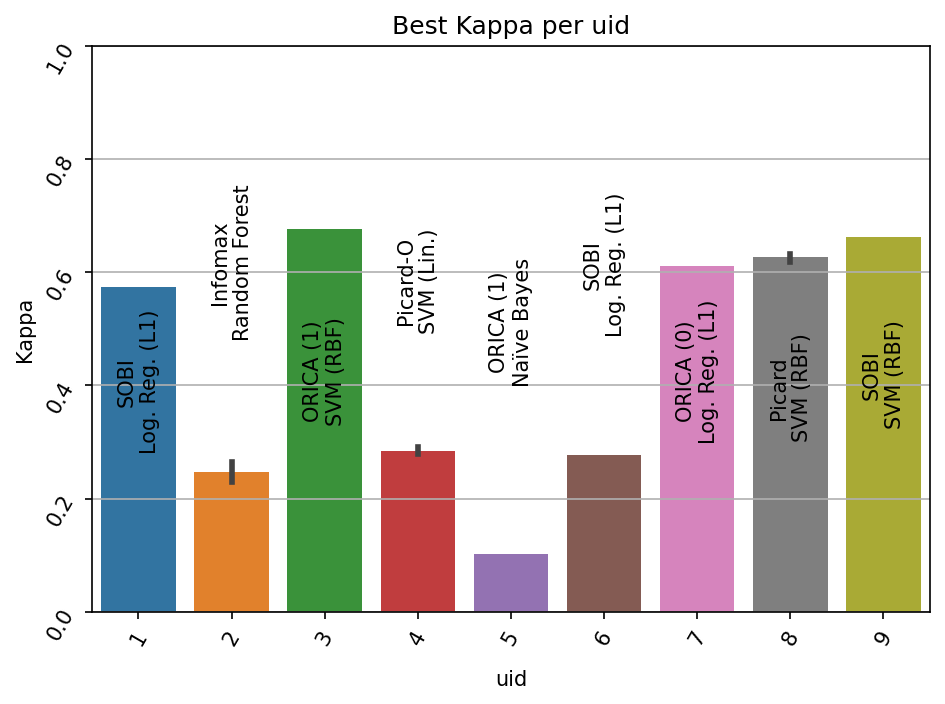

In [29]:
from ica_benchmark.visualization.multiple_runs import average_barplot, best_per_group_barplot

best_per_group_barplot(
    full_df,
    grouping_cols=["algorithm", "classifier"],
    x_col="uid",
    val_col="Kappa",
    figsize=None,
    x_label=None,
    save_filepath=None,
    ylim=None,
    title=None,
)

In [30]:
from scipy.stats import bootstrap, wilcoxon

def upper_ci(arr):
    return bootstrap((arr, ), np.mean, n_resamples=1000).confidence_interval.high

def low_ci(arr):
    return bootstrap((arr, ), np.mean, n_resamples=1000).confidence_interval.low


adf = (
    full_df
    .groupby(["algorithm", "classifier", "uid"], as_index=False).mean()
    .groupby(["algorithm", "classifier"], as_index=False).agg(["median", "mean", "std", low_ci, upper_ci])
    .reset_index()
    .sort_values(by=[("Kappa", "mean"), ("Kappa", "std")], ascending=[False, False])
    .drop_duplicates(subset=[("classifier", '')])
    .loc[:, ["classifier", "algorithm", "Kappa"]]
    .sort_values(by=[("Kappa", "mean"), ("Kappa", "std")], ascending=[False, False])
    .assign(
        CI=lambda df: df.apply(
            lambda row: "[{:.3f},{:.3f}]".format(
                row.Kappa.low_ci, row.Kappa.upper_ci
            ),
            axis=1
        )
    )
    .round(3)
    .loc[:, [("classifier", ""), ("algorithm", ""), ("Kappa", "median"), ("Kappa", "mean"), ("Kappa", "std")]]
    .rename(columns=dict(CI="CI (95%)"))
)
display(adf)

adf.to_latex(tex_path / "best_alg_per_clf_overall.tex", index=False)
adf = (
    full_df
    .groupby(["algorithm", "classifier", "uid"], as_index=False).mean()
    .groupby(["algorithm", "classifier"], as_index=False).agg(["median", "mean", "std", low_ci, upper_ci])
    .reset_index()
    .sort_values(by=[("Kappa", "mean"), ("Kappa", "std")], ascending=[False, False])
    .drop_duplicates(subset=[("algorithm", '')])
    .loc[:, ["algorithm", "classifier", "Kappa"]]
    .sort_values(by=[("Kappa", "mean"), ("Kappa", "std")], ascending=[False, False])
    .assign(
        CI=lambda df: df.apply(
            lambda row: "[{:.3f},{:.3f}]".format(
                row.Kappa.low_ci, row.Kappa.upper_ci
            ),
            axis=1
        )
    )
    .round(3)
#     .loc[:, [("algorithm", ""), ("classifier", ""), ("Kappa", "median"), ("Kappa", "mean"), ("CI", "")]]
    .loc[:, [("algorithm", ""), ("classifier", ""), ("Kappa", "median"), ("Kappa", "mean"), ("Kappa", "std")]]
    .rename(columns=dict(CI="CI (95%)"))
)
display(adf)
adf.to_latex(tex_path / "best_clf_per_alg_overall.tex", index=False)

/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:119: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = num / den
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:93: BootstrapDegenerateDistributionWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(BootstrapDegenerateDistributionWarning())
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:119: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = num / den
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:93: BootstrapDegenerateDistributionWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(BootstrapDegenerateDistributionWarning())
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:125: RuntimeWarning: invalid value

classifier  algorithm  Kappa              
                               median   mean    std
88   Log. Reg. (L2)     Picard  0.498  0.380  0.199
14        Log. Reg.    FastICA  0.468  0.378  0.207
15   Log. Reg. (L1)    FastICA  0.486  0.377  0.207
85              LDA     Picard  0.477  0.373  0.187
79    Random Forest  ORICA (1)  0.438  0.373  0.231
20       SVM (Lin.)    FastICA  0.452  0.371  0.203
23       SVM (Sig.)    FastICA  0.460  0.369  0.205
94        SVM (RBF)     Picard  0.435  0.368  0.190
17              MLP    FastICA  0.448  0.368  0.198
72      Extra Trees  ORICA (1)  0.439  0.348  0.235
18      Naïve Bayes    FastICA  0.345  0.324  0.200
105      SVM (Poly)   Picard-O  0.377  0.319  0.194

/tmp/ipykernel_16880/1643193384.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  adf.to_latex(tex_path / "best_alg_per_clf_overall.tex", index=False)
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:119: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = num / den
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:93: BootstrapDegenerateDistributionWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(BootstrapDegenerateDistributionWarning())
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:119: RuntimeWarning: invalid value encountered in scalar di

algorithm      classifier  Kappa              
                                  median   mean    std
88         Picard  Log. Reg. (L2)  0.498  0.380  0.199
16        FastICA  Log. Reg. (L2)  0.464  0.379  0.209
99       Picard-O  Log. Reg. (L1)  0.480  0.373  0.219
79      ORICA (1)   Random Forest  0.438  0.373  0.231
28        Infomax  Log. Reg. (L2)  0.438  0.356  0.197
3    Ext. Infomax  Log. Reg. (L1)  0.439  0.355  0.211
111          SOBI  Log. Reg. (L1)  0.278  0.344  0.229
63      ORICA (0)  Log. Reg. (L1)  0.472  0.344  0.260
38           JADE       Log. Reg.  0.278  0.291  0.147
49           None             LDA  0.259  0.248  0.177

/tmp/ipykernel_16880/1643193384.py:57: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  adf.to_latex(tex_path / "best_clf_per_alg_overall.tex", index=False)


In [31]:
adf = (
    full_df
    .groupby(["algorithm", "classifier", "uid"], as_index=False).mean()
    .groupby(["algorithm", "classifier"], as_index=False).agg(["median", "mean", "std", low_ci, upper_ci])
    .reset_index()
    .sort_values(by=[("Kappa", "mean"), ("Kappa", "std")], ascending=[False, False])
    .round(3)
    .loc[:, [("algorithm", ""), ("classifier", ""), ("Kappa", "median"), ("Kappa", "mean"), ("Kappa", "std")]]
    .rename(columns=dict(CI="CI (95%)"))
    .head(10)
)
adf.to_latex(tex_path / "top_10_comb.tex", index=False)
adf

/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:119: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = num / den
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:93: BootstrapDegenerateDistributionWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(BootstrapDegenerateDistributionWarning())
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:119: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = num / den
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:93: BootstrapDegenerateDistributionWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(BootstrapDegenerateDistributionWarning())
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:125: RuntimeWarning: invalid value

algorithm      classifier  Kappa              
                              median   mean    std
88     Picard  Log. Reg. (L2)  0.498  0.380  0.199
16    FastICA  Log. Reg. (L2)  0.464  0.379  0.209
14    FastICA       Log. Reg.  0.468  0.378  0.207
15    FastICA  Log. Reg. (L1)  0.486  0.377  0.207
86     Picard       Log. Reg.  0.487  0.376  0.198
87     Picard  Log. Reg. (L1)  0.492  0.375  0.195
99   Picard-O  Log. Reg. (L1)  0.480  0.373  0.219
85     Picard             LDA  0.477  0.373  0.187
79  ORICA (1)   Random Forest  0.438  0.373  0.231
20    FastICA      SVM (Lin.)  0.452  0.371  0.203

In [32]:
from scipy.stats import bootstrap, wilcoxon

def upper_ci(arr):
    return bootstrap((arr, ), np.mean, n_resamples=1000).confidence_interval.high

def low_ci(arr):
    return bootstrap((arr, ), np.mean, n_resamples=1000).confidence_interval.low


adf = (
    full_df
    .groupby(["algorithm", "classifier", "uid"], as_index=False).mean()
    .groupby(["algorithm", "classifier"], as_index=False).mean()
    .groupby(["algorithm"], as_index=False).agg(["median", "mean", "std", low_ci, upper_ci])
    .reset_index()
    .loc[:, ["algorithm", "Kappa"]]
    .sort_values(by=[("Kappa", "mean"), ("Kappa", "std")], ascending=[False, False])
    .assign(
        CI=lambda df: df.apply(
            lambda row: "[{:.3f},{:.3f}]".format(
                row.Kappa.low_ci, row.Kappa.upper_ci
            ),
            axis=1
        )
    )
    .round(3)
    .loc[:, [("algorithm", ""), ("Kappa", "median"), ("Kappa", "mean"), ("Kappa", "std")]]
    .rename(columns=dict(CI="CI (95%)"))
)
display(adf)
adf.to_latex(tex_path / "alg_results.tex", index=False)


adf = (
    full_df
    .groupby(["classifier", "algorithm", "uid"], as_index=False).mean()
    .groupby(["classifier", "algorithm"], as_index=False).mean()
    .groupby(["classifier"], as_index=False).agg(["median", "mean", "std", low_ci, upper_ci])
    .reset_index()
    .loc[:, ["classifier", "Kappa"]]
    .sort_values(by=[("Kappa", "mean"), ("Kappa", "std")], ascending=[False, False])
    .assign(
        CI=lambda df: df.apply(
            lambda row: "[{:.3f},{:.3f}]".format(
                row.Kappa.low_ci, row.Kappa.upper_ci
            ),
            axis=1
        )
    )
    .round(3)
    .loc[:, [("classifier", ""), ("Kappa", "median"), ("Kappa", "mean"), ("Kappa", "std")]]
    .rename(columns=dict(CI="CI (95%)"))
)
display(adf)
adf.to_latex(tex_path / "clf_results.tex", index=False)


/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:119: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = num / den
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:93: BootstrapDegenerateDistributionWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(BootstrapDegenerateDistributionWarning())
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:119: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = num / den
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:93: BootstrapDegenerateDistributionWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(BootstrapDegenerateDistributionWarning())
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:125: RuntimeWarning: invalid value

algorithm  Kappa              
                median   mean    std
1       FastICA  0.366  0.359  0.022
7        Picard  0.368  0.358  0.024
8      Picard-O  0.363  0.354  0.022
6     ORICA (1)  0.359  0.350  0.024
2       Infomax  0.347  0.340  0.019
0  Ext. Infomax  0.342  0.336  0.020
9          SOBI  0.328  0.321  0.024
5     ORICA (0)  0.335  0.320  0.027
3          JADE  0.272  0.268  0.016
4          None  0.238  0.222  0.029

/tmp/ipykernel_16880/1850257346.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  adf.to_latex(tex_path / "alg_results.tex", index=False)
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:119: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = num / den
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:93: BootstrapDegenerateDistributionWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(BootstrapDegenerateDistributionWarning())
/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:119: RuntimeWarning: invalid value encountered in scalar divide
  a_hat 

classifier  Kappa              
                   median   mean    std
2        Log. Reg.  0.352  0.341  0.043
4   Log. Reg. (L2)  0.354  0.341  0.045
3   Log. Reg. (L1)  0.356  0.340  0.048
8       SVM (Lin.)  0.349  0.336  0.043
10       SVM (RBF)  0.342  0.333  0.042
5              MLP  0.341  0.331  0.045
1              LDA  0.342  0.330  0.041
11      SVM (Sig.)  0.345  0.328  0.043
7    Random Forest  0.346  0.323  0.056
0      Extra Trees  0.333  0.310  0.049
6      Naïve Bayes  0.307  0.287  0.049
9       SVM (Poly)  0.290  0.276  0.039

/tmp/ipykernel_16880/1850257346.py:55: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  adf.to_latex(tex_path / "clf_results.tex", index=False)


In [33]:
(
    full_df
    .groupby(["algorithm", "classifier", "uid"], as_index=False).mean()
    .sort_values(by=["uid", "Kappa"], ascending=[True, False])
    .drop_duplicates(subset=["uid"])
    .groupby(["algorithm", "classifier"], as_index=False).agg(["count", "mean", list])
    .loc[:, [("uid", "count"), ("uid", "list"), ("Kappa", "mean")]] #, ("Kappa", "list")]]
    .sort_values(by=("uid", "count"), ascending=False)
    .head()
)

uid             Kappa
                         count    list      mean
algorithm classifier                            
SOBI      Log. Reg. (L1)     2  [1, 6]  0.425926
Infomax   Random Forest      1     [2]  0.247222
ORICA (0) Log. Reg. (L1)     1     [7]  0.611111
ORICA (1) Log. Reg.          1     [3]  0.675926
          Naïve Bayes        1     [5]  0.101852

In [34]:
# Average by (ICA, Classifier)
(
    full_df
    .groupby(["algorithm", "classifier", "uid"], as_index=False).mean()
    .groupby(["algorithm", "classifier"], as_index=False).agg(["count", "median"])
    .loc[:, [("Kappa", "median")]] #, ("Kappa", "list")]]
    .sort_values(by=("Kappa", "median"), ascending=False)
    .head()
)

Kappa
                            median
algorithm classifier              
Picard    Log. Reg. (L2)  0.498148
          Log. Reg. (L1)  0.491667
          Log. Reg.       0.487037
FastICA   Log. Reg. (L1)  0.485648
Picard-O  Log. Reg. (L2)  0.485185

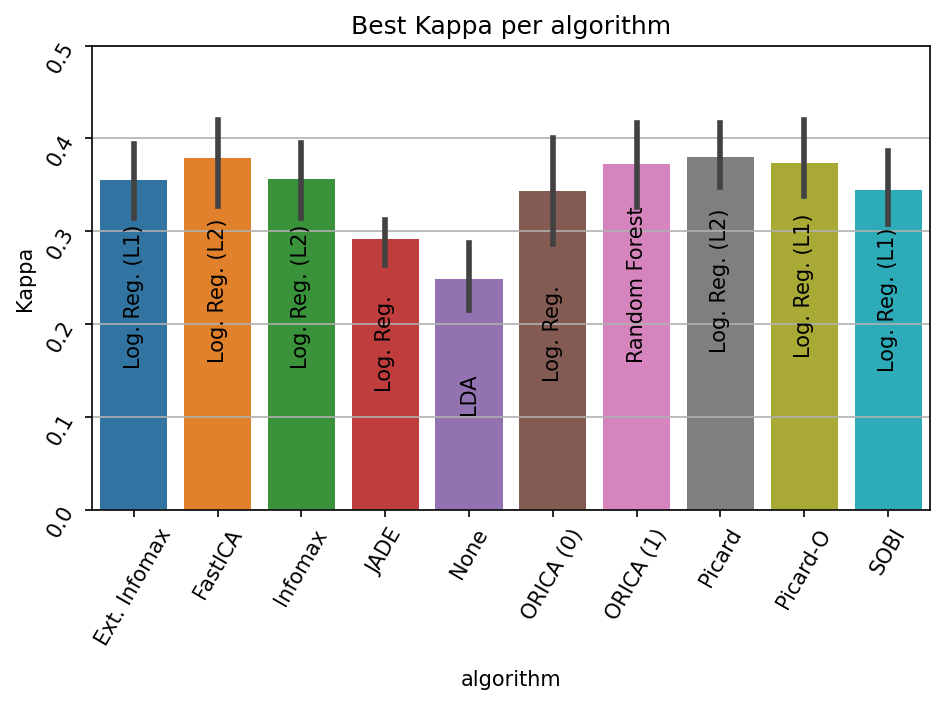

In [35]:

best_per_group_barplot(
    full_df,
    grouping_cols=["classifier"],
    x_col="algorithm",
    val_col="Kappa",
    figsize=None,
    x_label=None,
    save_filepath=None,
    ylim=(0, .5),
    title=None,
)


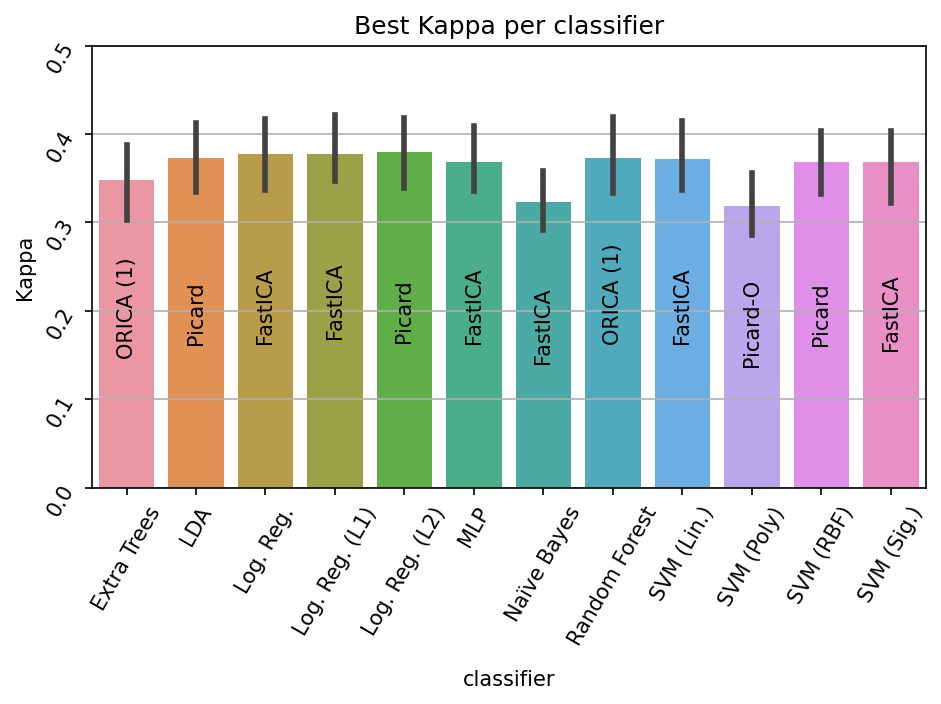

In [36]:

best_per_group_barplot(
    full_df,
    grouping_cols=["algorithm"],
    x_col="classifier",
    val_col="Kappa",
    figsize=None,
    x_label=None,
    save_filepath=None,
    ylim=(0, .5),
    title=None,
)

In [37]:
adf = (
    full_df
    .groupby(["algorithm", "classifier", "uid"], as_index=False).mean()
    .groupby(["algorithm", "classifier"], as_index=False).mean()
#     .groupby(["algorithm"], as_index=False).agg(["median", "mean", "std"])
#     .Kappa
    .sort_values(by="Kappa", ascending=False)
    .drop_duplicates(subset=["algorithm"])
    .loc[:, ["algorithm", "classifier", "Kappa"]]
#     .reset_index()
)
display(adf)

,algorithm,classifier,Kappa
88,Picard,Log. Reg. (L2),0.379527
16,FastICA,Log. Reg. (L2),0.378807
99,Picard-O,Log. Reg. (L1),0.372942
79,ORICA (1),Random Forest,0.372634
28,Infomax,Log. Reg. (L2),0.355864
3,Ext. Infomax,Log. Reg. (L1),0.355453
111,SOBI,Log. Reg. (L1),0.344136
63,ORICA (0),Log. Reg. (L1),0.343621
38,JADE,Log. Reg.,0.291152
49,None,LDA,0.248457


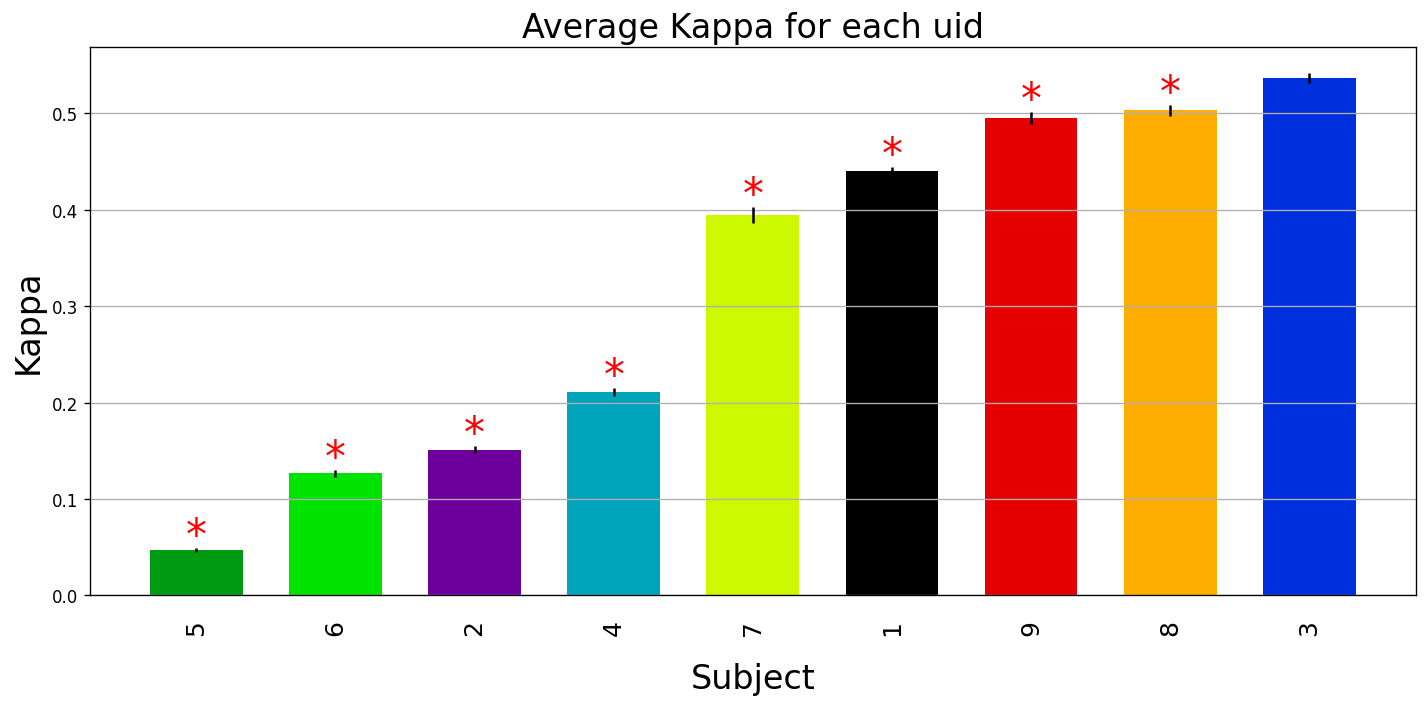

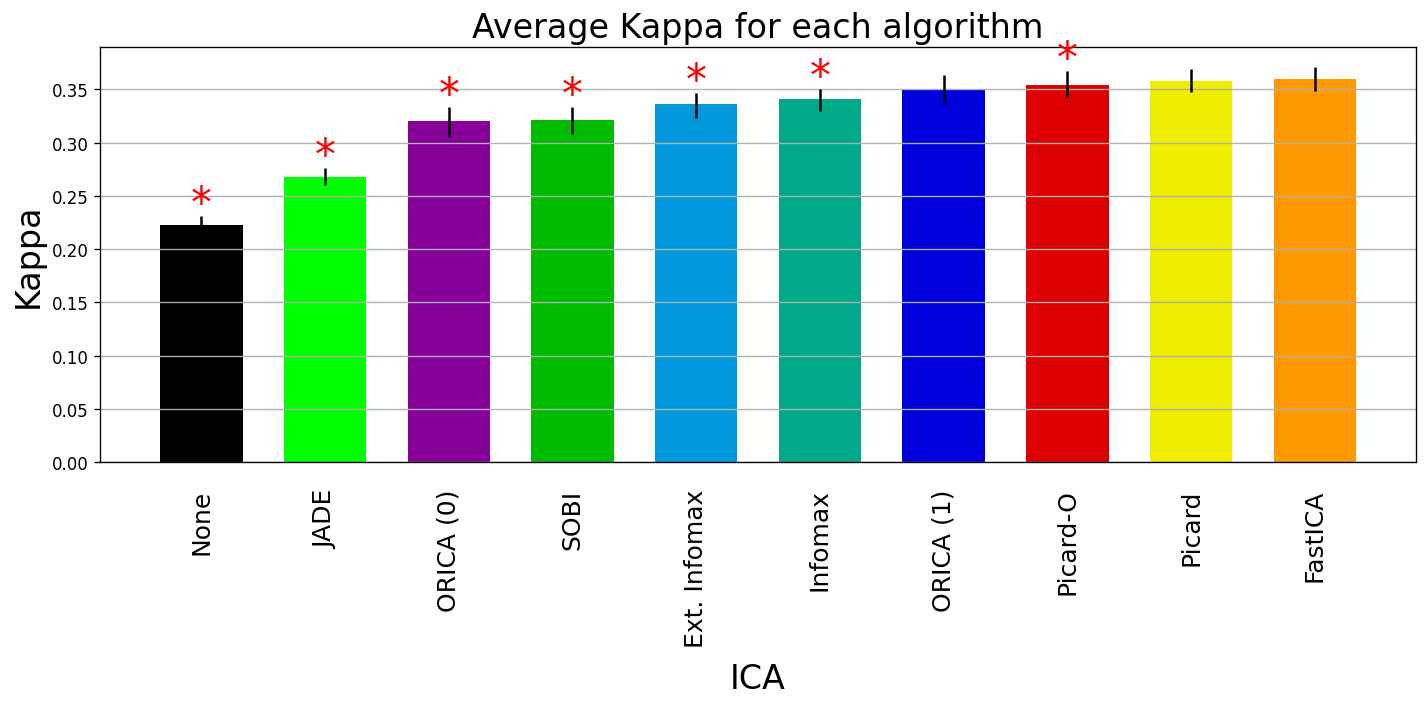

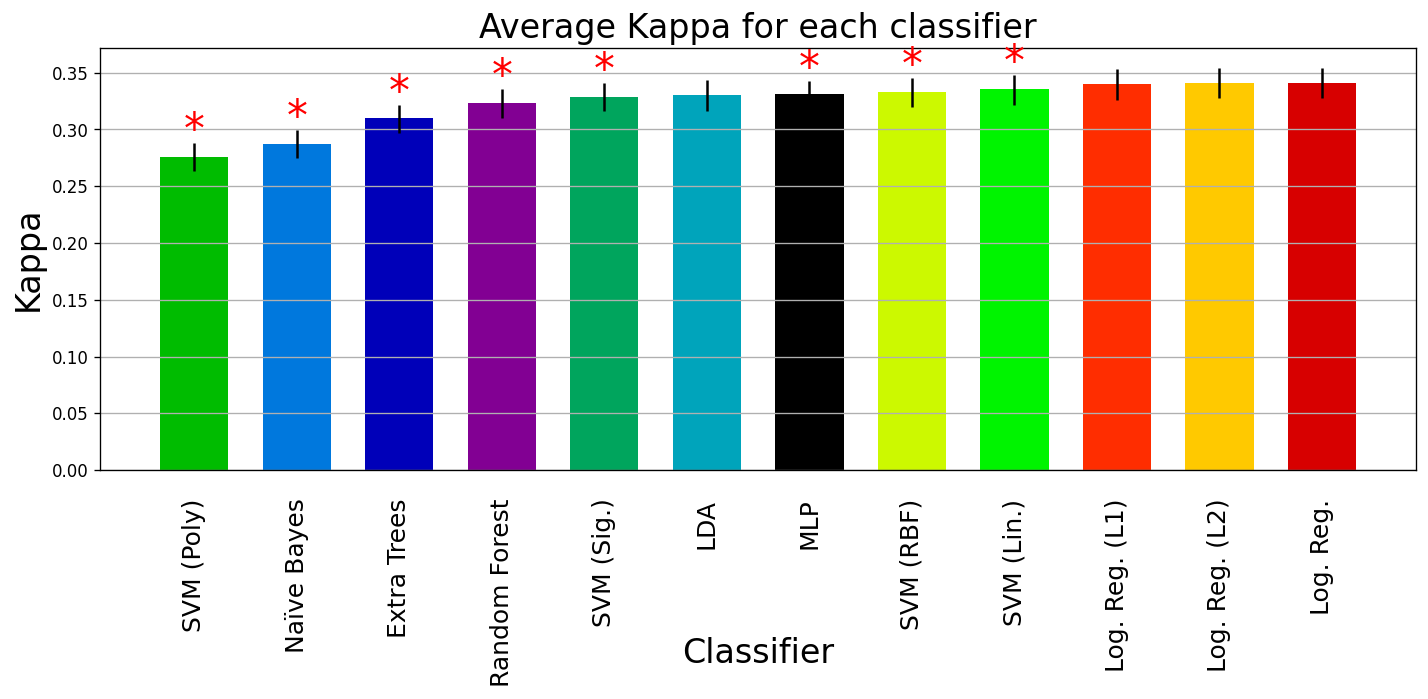

In [38]:
results_df = full_df

kwargs = dict(
    n_boots=1000,
    figsize=(12, 6),
    legend_in=None
)
average_barplot(
    results_df,
    x_col="uid",
    grouping_cols=["algorithm", "classifier"],
    val_col="Kappa",
    key_cols="run",
    x_label="Subject",
    labelpad=40,
    **kwargs
)

average_barplot(
    results_df,
    x_col="algorithm",
    grouping_cols=["uid", "classifier"],
    val_col="Kappa",
    key_cols="run",
    x_label="ICA",
    labelpad=120,
    **kwargs
)

average_barplot(
    results_df,
    x_col="classifier",
    grouping_cols=["uid", "algorithm"],
    val_col="Kappa",
    key_cols="run",
    x_label="Classifier",
    labelpad=100,
    **kwargs
)


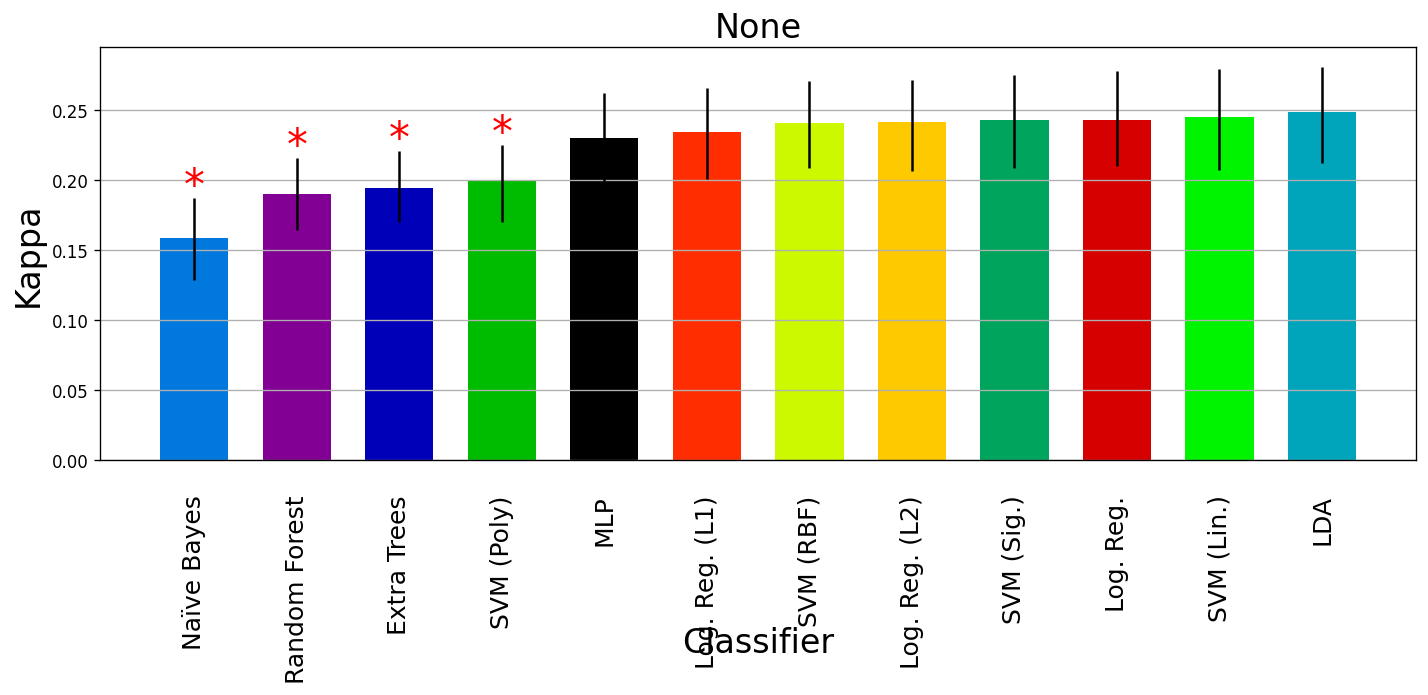

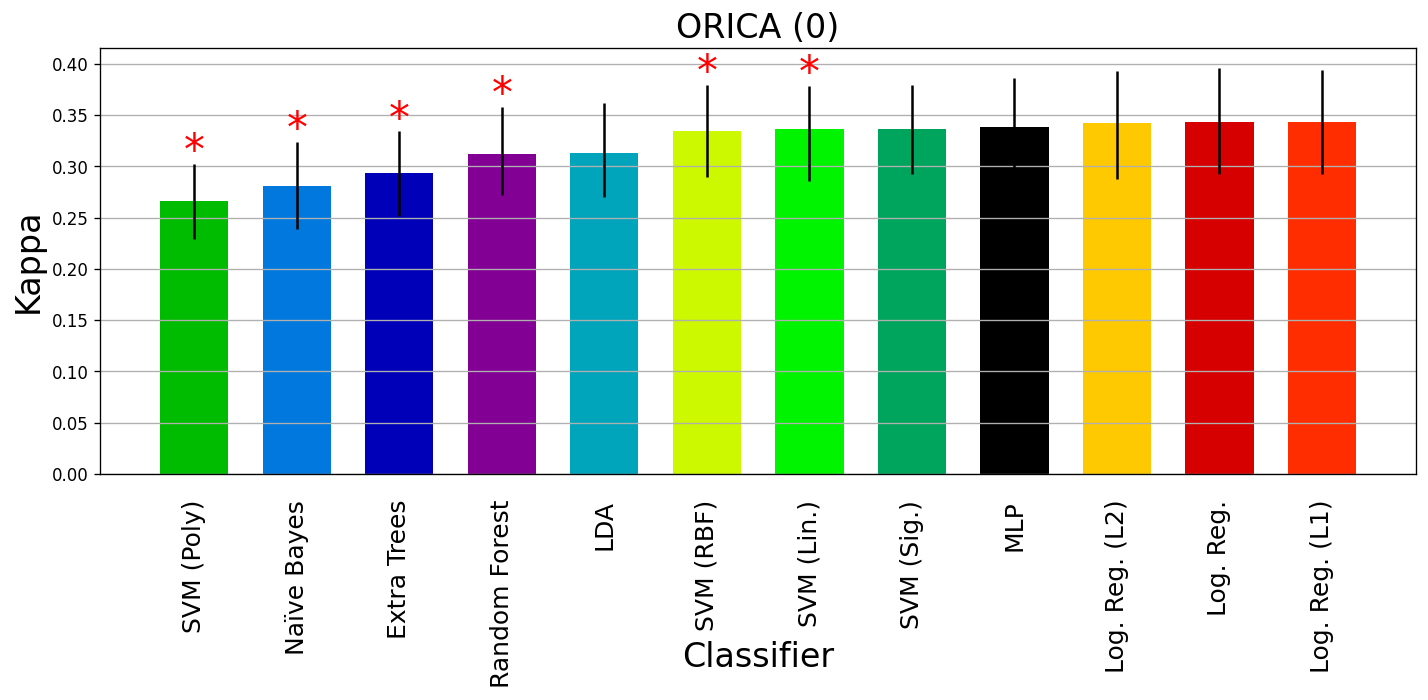

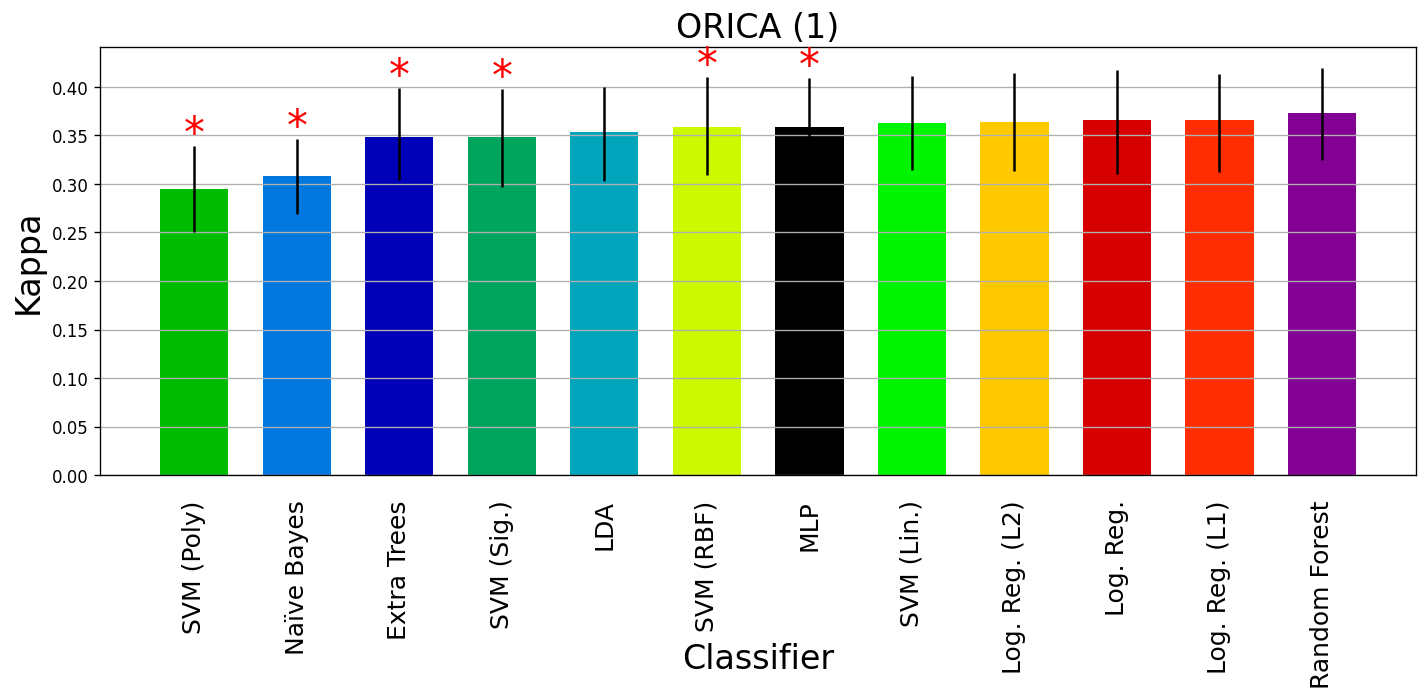

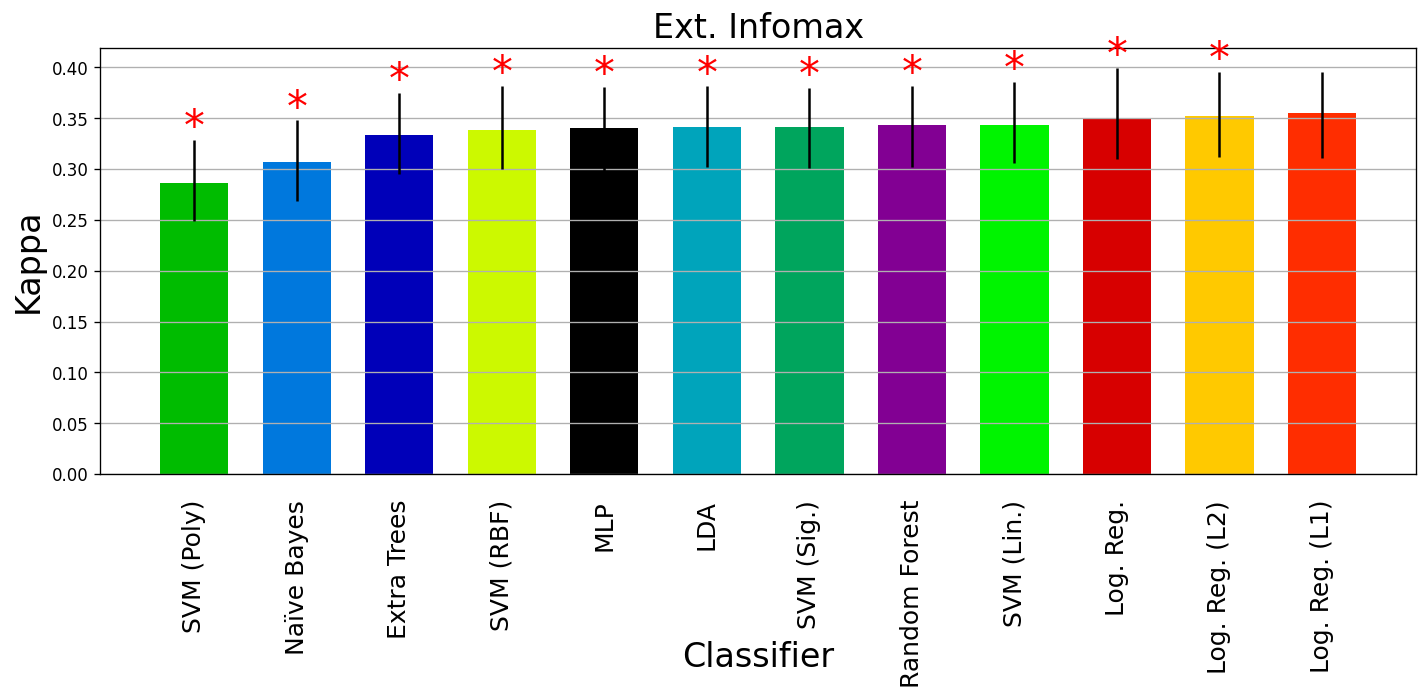

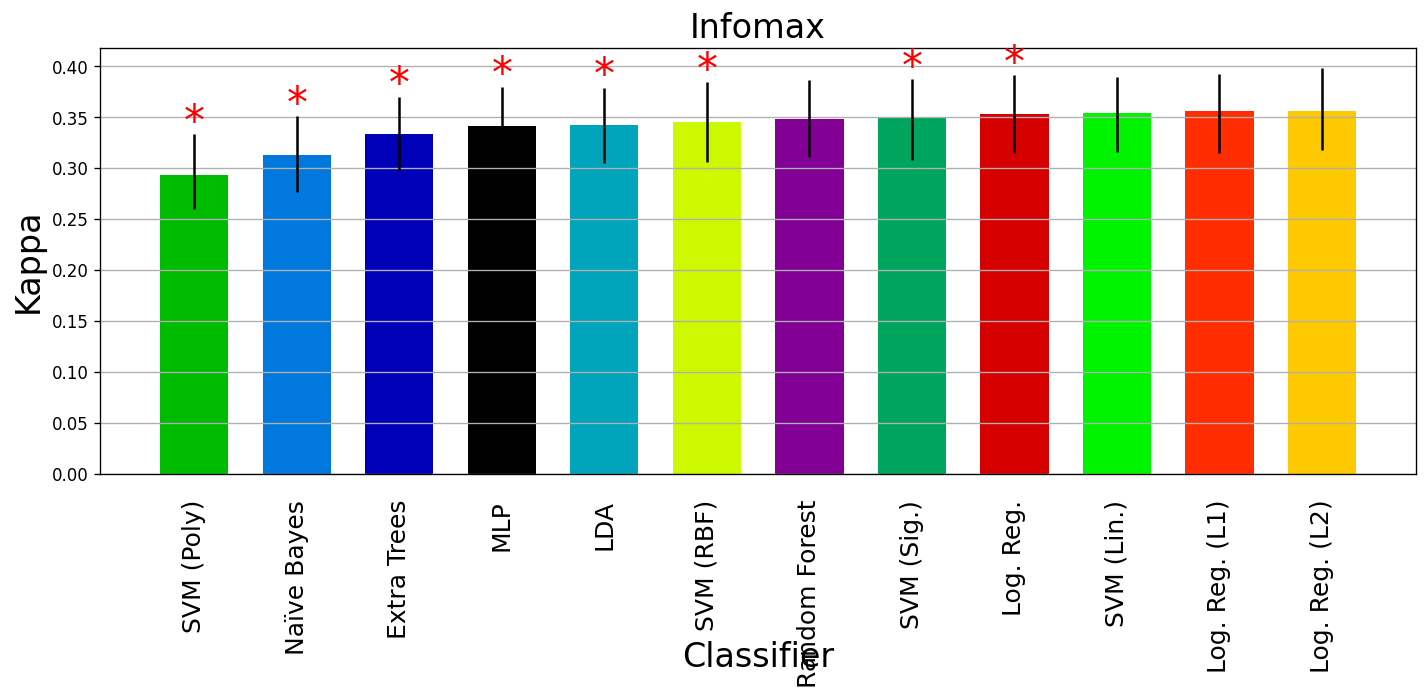

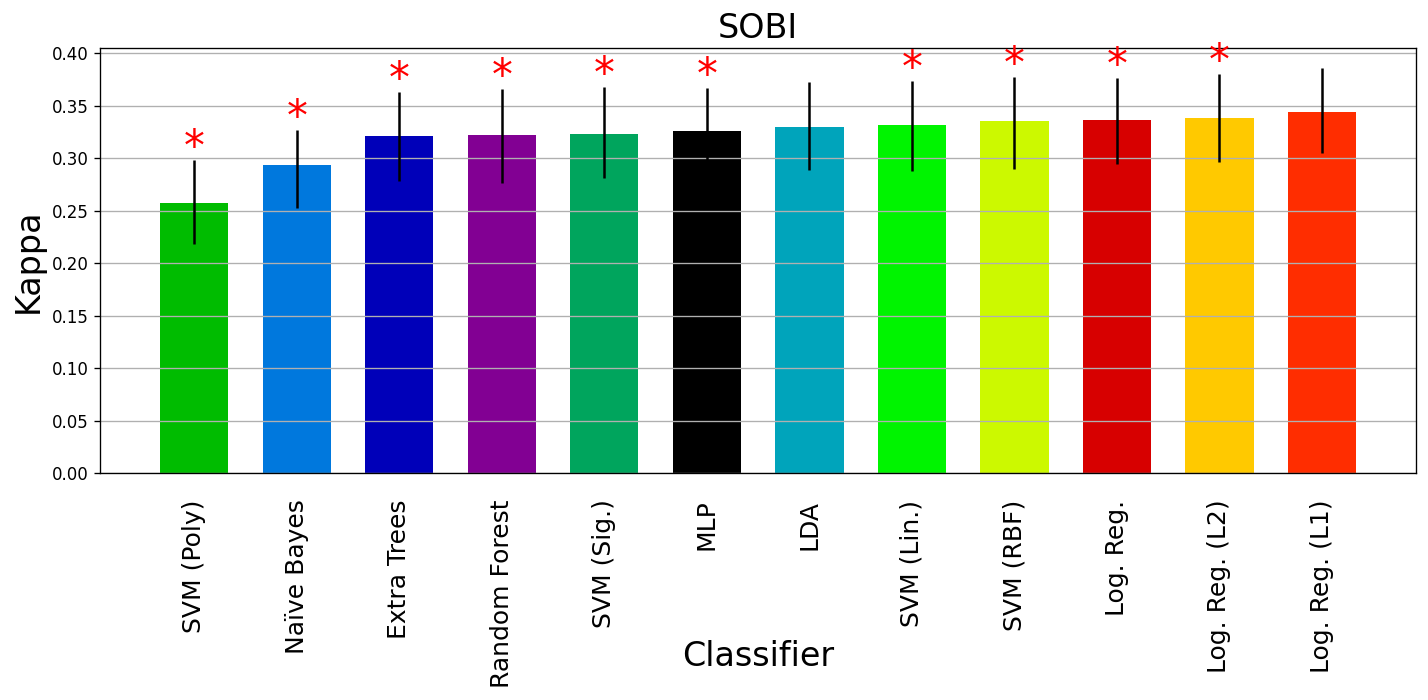

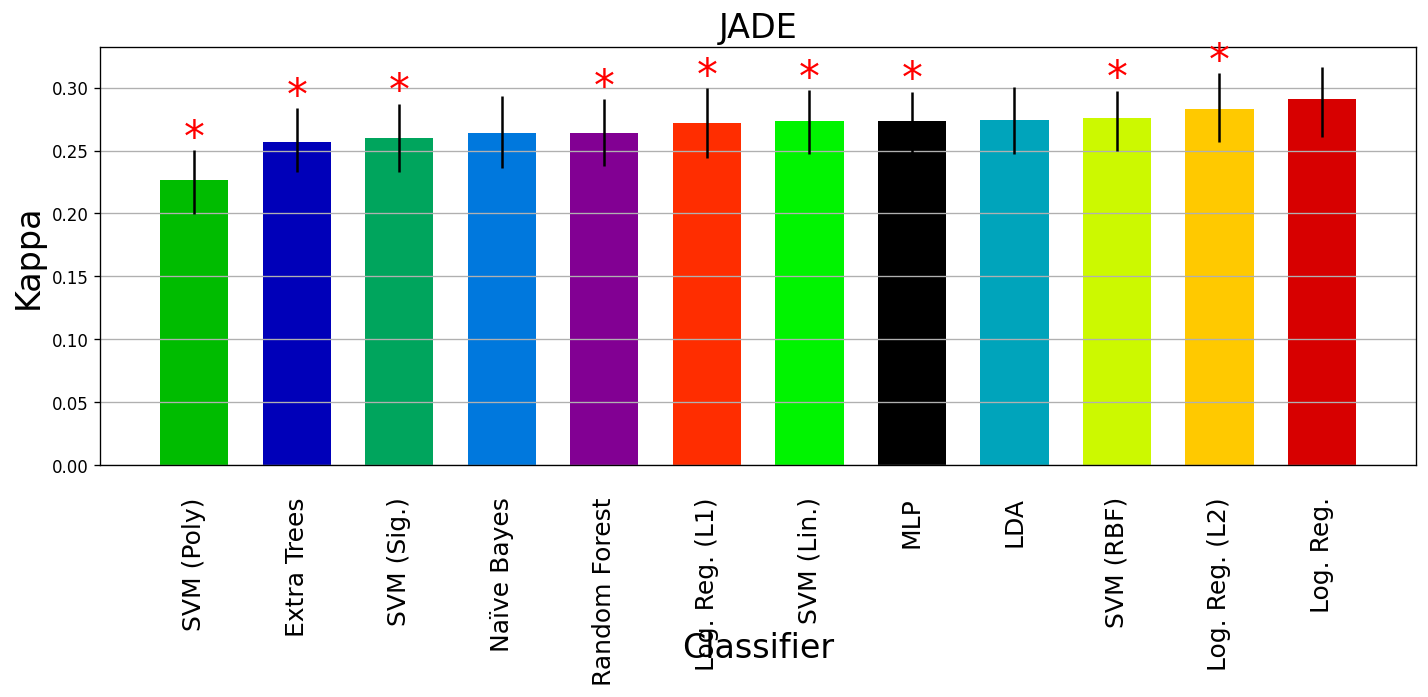

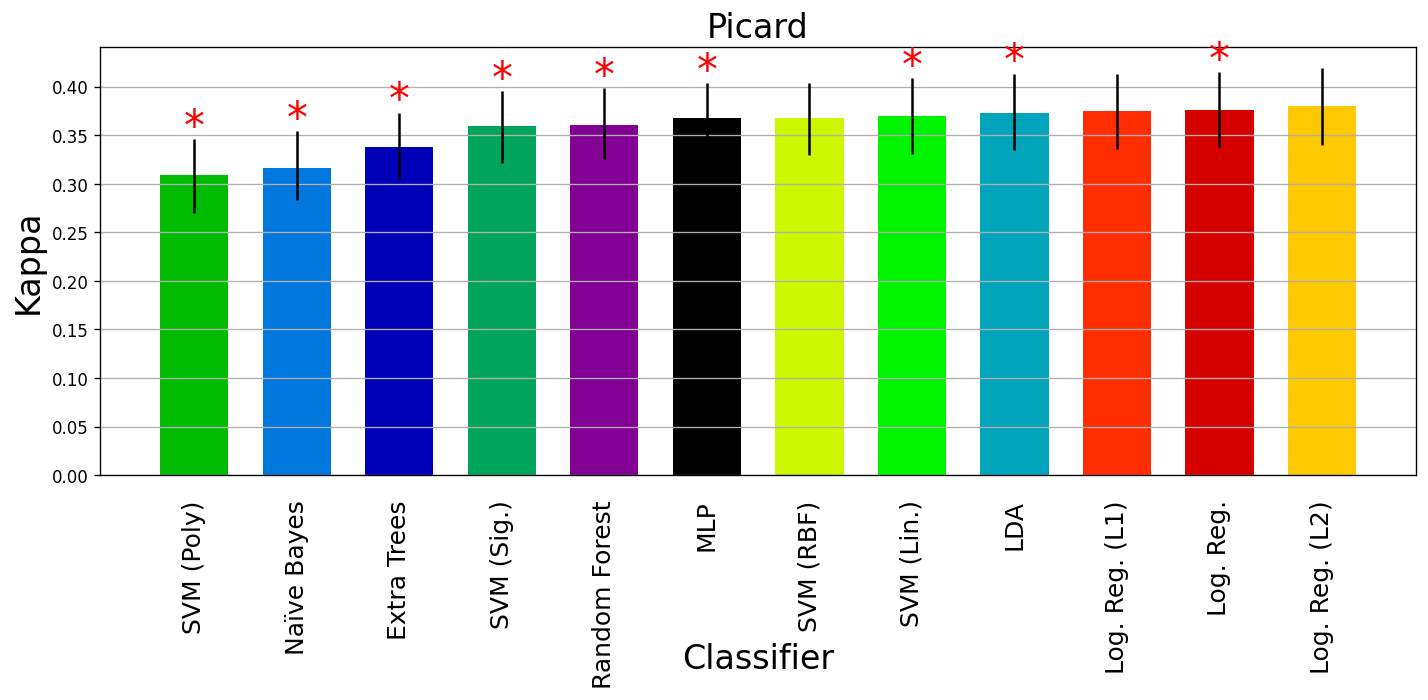

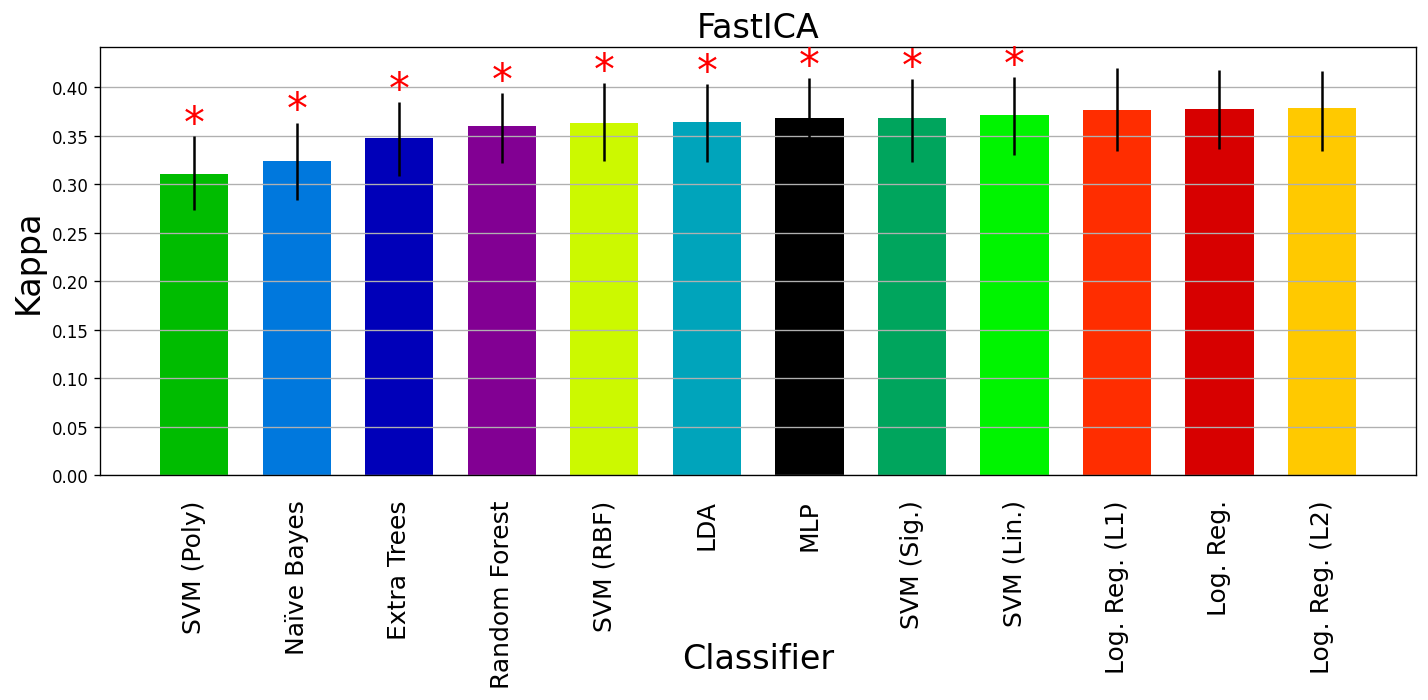

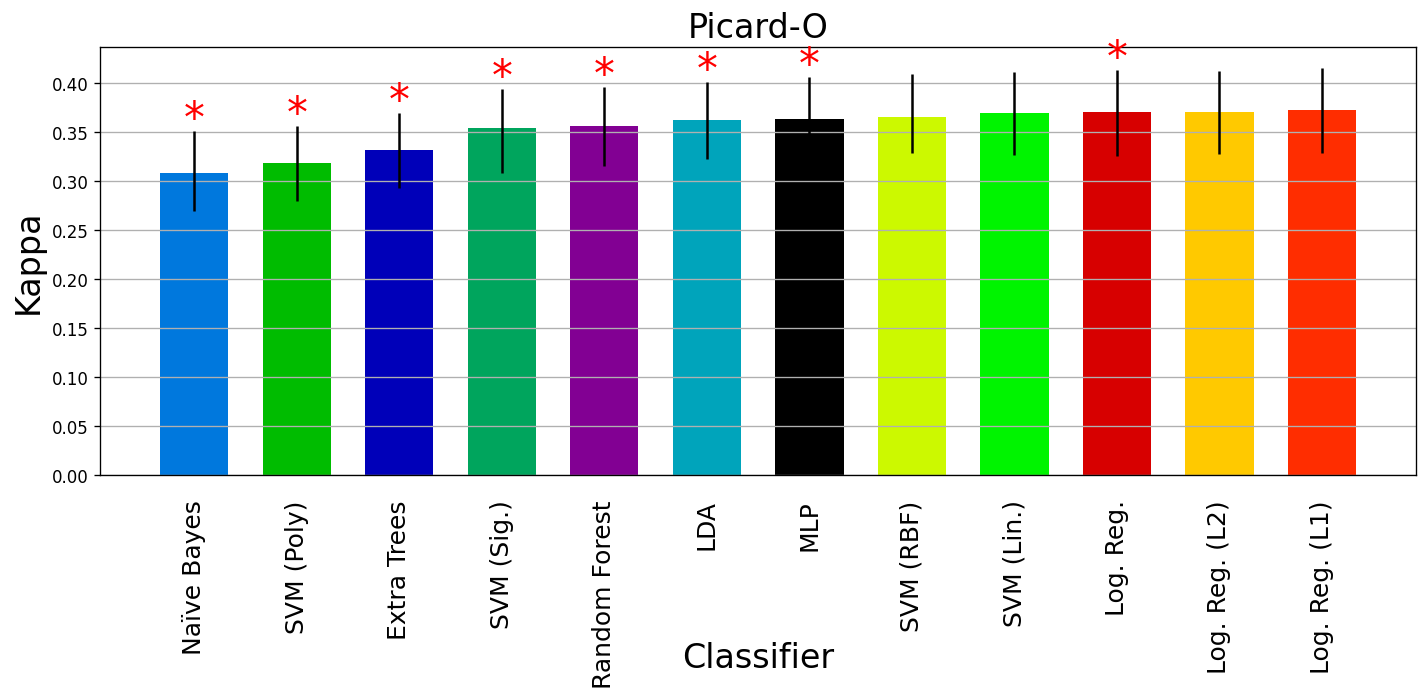

In [39]:
for alg in results_df.algorithm.unique():
    average_barplot(
        results_df.query("algorithm == @alg"),
        x_col="classifier",
        grouping_cols=["uid"],
        val_col="Kappa",
        key_cols="run",
        x_label="Classifier",
        title=alg,
        labelpad=100,
        **kwargs
    )

In [40]:
from statsmodels.regression.mixed_linear_model import VCSpec
import statsmodels.api as sm
df = full_df
vc = {"g1": "0 + C(classifier)", "g2": "0 + C(algorithm)", "g3": "0 + C(uid)"}
oo = np.ones(df.shape[0])
model3 = sm.MixedLM.from_formula("Kappa ~ 1", groups=oo, vc_formula=vc, data=df)
result = model3.fit()
print(result.summary())
np.sqrt(result.scale * result.params)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Kappa     
No. Observations: 10800   Method:             REML      
No. Groups:       1       Scale:              0.0056    
Min. group size:  10800   Log-Likelihood:     12539.1792
Max. group size:  10800   Converged:          Yes       
Mean group size:  10800.0                               
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   0.323     0.065  5.002  0.000   0.196   0.449
g1 Var      0.000     0.003                              
g2 Var      0.002     0.012                              
g3 Var      0.035     0.236                              



/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Intercept    0.042694
g1 Var       0.021088
g2 Var       0.044469
g3 Var       0.188111
dtype: float64

In [41]:
from statsmodels.regression.mixed_linear_model import VCSpec
import statsmodels.api as sm
df = full_df
vc = {"g2": "0 + C(algorithm) * C(uid)"}
vc = {"g1": "0 + C(algorithm)", "g2": "0 + C(uid)", "g3": "0 + C(algorithm):C(uid)"}
oo = np.ones(df.shape[0])
model3 = sm.MixedLM.from_formula("Kappa ~ 1", groups=oo, vc_formula=vc, data=df)
result = model3.fit()
print(result.summary())
np.sqrt(result.scale * result.params)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Kappa     
No. Observations: 10800   Method:             REML      
No. Groups:       1       Scale:              0.0022    
Min. group size:  10800   Log-Likelihood:     17400.6389
Max. group size:  10800   Converged:          Yes       
Mean group size:  10800.0                               
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   0.323     0.064  5.057  0.000   0.198   0.448
g1 Var      0.001     0.020                              
g2 Var      0.035     0.376                              
g3 Var      0.005     0.017                              



/home/paulo/miniconda3/envs/bci/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Intercept    0.026756
g1 Var       0.038215
g2 Var       0.186814
g3 Var       0.069223
dtype: float64

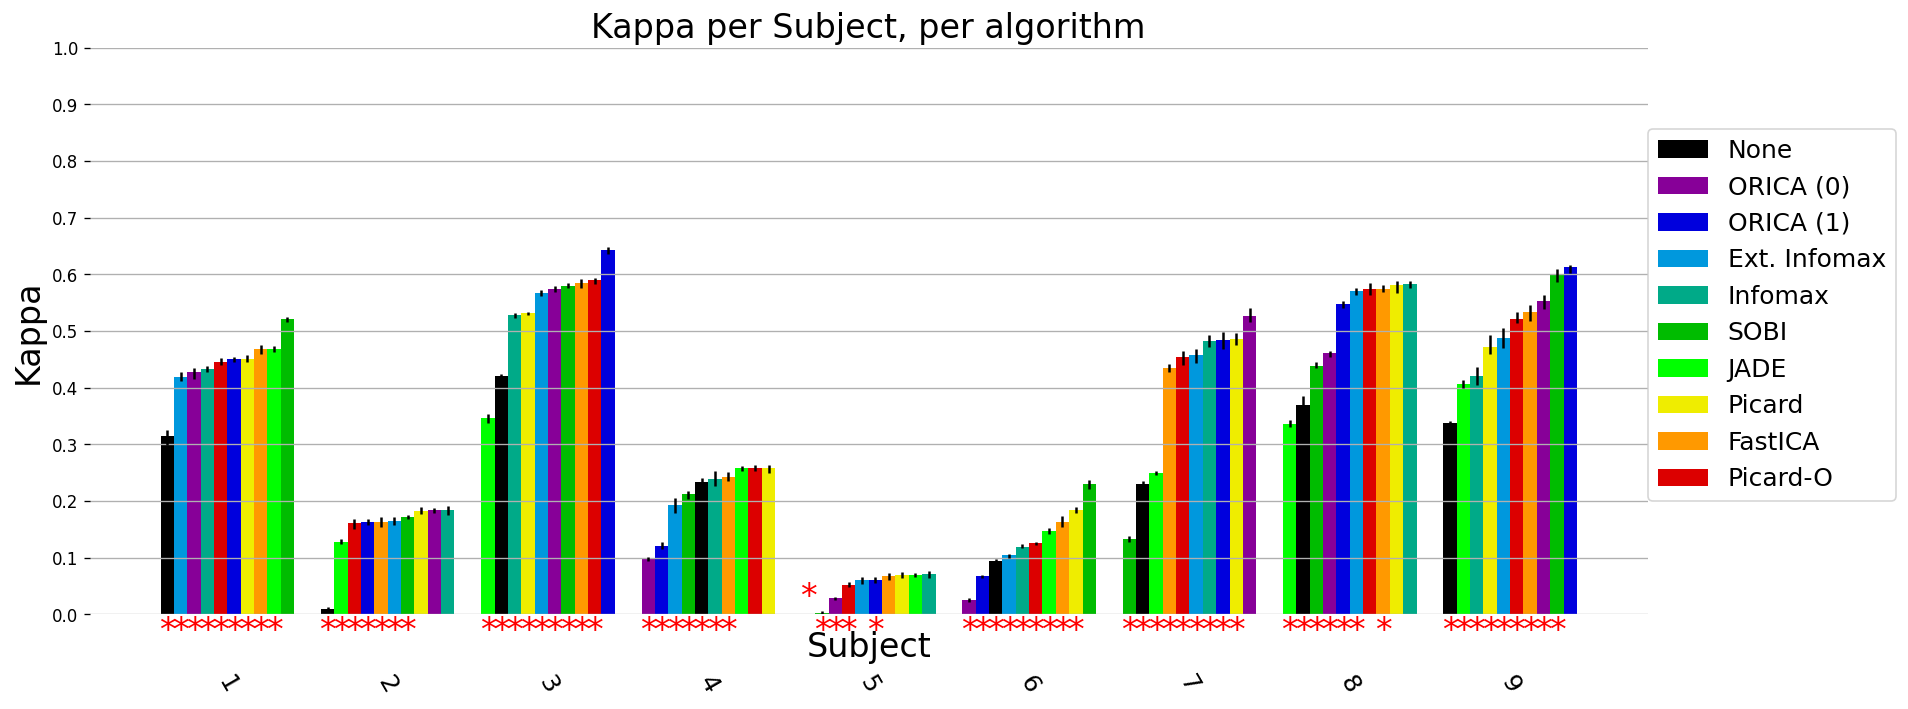

In [42]:
from ica_benchmark.visualization.multiple_runs import detailed_barplot

detailed_barplot(
    full_df,
    x_col='uid',
    hue_col='algorithm',
    val_col="Kappa",
    key_cols=['run', "classifier"],
    save_filepath=None,
    w=5,
    cmap='nipy_spectral',
    x_label="Subject",
    y_label="Kappa",
#     title="Number of epochs per ICA method, per subject",
#     ylim=(0, 1200),
#     ast_loc=(-30, 10),
#     labelpad=30,
#     tick_pad=-40
)